<a href="https://colab.research.google.com/github/nickkolev97/Tip_deconvolution_hack/blob/main/1_AFM_Imperfect_Probe_COLAB_Hackathon_Nick_copy.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# AFM Digital Twin: Imperfect Probe Example

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/pycroscopy/DTMicroscope/blob/main/notebooks/AFM/1_AFM_Imperfect_Probe_COLAB_Hackaton.ipynb)


## Task Overview

Participants are invited to develop methods for recovering the **"true" image** from SPM scans affected by probe artifacts, such as variable probe sizes and double tips.

---

### **Key Question**

> **Given a corrupted SPM image affected by probe artifacts, can we automatically detect these distortions and accurately reconstruct the original, undistorted image?**


# 1. Run server

In [1]:
!pip install pyro5
!pip install scifireaders
!pip install sidpy
!pip install pynsid
!pip install git+https://github.com/pycroscopy/DTMicroscope.git

  Cloning https://github.com/pycroscopy/DTMicroscope.git to /tmp/pip-req-build-jvxh62sa
  Running command git clone --filter=blob:none --quiet https://github.com/pycroscopy/DTMicroscope.git /tmp/pip-req-build-jvxh62sa
  Resolved https://github.com/pycroscopy/DTMicroscope.git to commit 3a7dcb0345db7dc56e82106593ec2cbe151dbd53
  Preparing metadata (setup.py) ... done


In [2]:
!run_server_afm

You don't have igor2 installed.     If you wish to open igor files, you will need to install it     (pip install igor2) before attempting.
You don't have gwyfile installed.     If you wish to open .gwy files, you will need to      install it (pip install gwyfile) before attempting.
Server started and running in the background. Logs are being written to server.log.


# 2. Client side

In [3]:
import matplotlib.pylab as plt
import numpy as np
import Pyro5.api
from IPython.display import clear_output, display

## 2.1 Get data

In [4]:
!wget https://github.com/pycroscopy/DTMicroscope/raw/boris_dev/DTMicroscope/test/datasets/dset_spm1.h5

--2024-12-17 15:30:22--  https://github.com/pycroscopy/DTMicroscope/raw/boris_dev/DTMicroscope/test/datasets/dset_spm1.h5
Resolving github.com (github.com)... 140.82.116.3
Connecting to github.com (github.com)|140.82.116.3|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/pycroscopy/DTMicroscope/boris_dev/DTMicroscope/test/datasets/dset_spm1.h5 [following]
--2024-12-17 15:30:22--  https://raw.githubusercontent.com/pycroscopy/DTMicroscope/boris_dev/DTMicroscope/test/datasets/dset_spm1.h5
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.109.133, 185.199.108.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.109.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 22317256 (21M) [application/octet-stream]
Saving to: ‘dset_spm1.h5.2’

dset_spm1.h5.2      100%[===================>]  21.28M   125MB/s    in 0.2s    

2024-12-17 15

## 2.2 Register Data to the Digital twin

In [23]:
uri = "PYRO:microscope.server@localhost:9092" #port for the AFM DT 9092
mic_server = Pyro5.api.Proxy(uri)
import sys

if 'google.colab' in sys.modules:
    mic_server.initialize_microscope("AFM", data_path = r"dset_spm1.h5" )#r"dset_spm1.h5")
else:
    mic_server.initialize_microscope("AFM", data_path = "../test/datasets/dset_spm1.h5")
mic_server.setup_microscope(data_source = 'Compound_Dataset_1')#upload dataset?
mic_server.get_dataset_info()

[('channels',
  ['Channel_000',
   'Channel_001',
   'Channel_002',
   'Channel_003',
   'Channel_004',
   'Channel_005',
   'Channel_006']),
 ('signals',
  ['HeightRetrace',
   'Amplitude1Retrace',
   'Amplitude2Retrace',
   'Phase1Retrace',
   'Phase2Retrace',
   'FrequencyRetrace',
   'Response']),
 ('units', ['m', 'm', 'm', 'deg', 'deg', 'm', 'a.u.']),
 ('scans', [0, 1, 2, 3, 4, 5]),
 ('spectra', []),
 ('point_clouds', [6])]

## Artefact 0: Blunt 'needle' with an offset tip

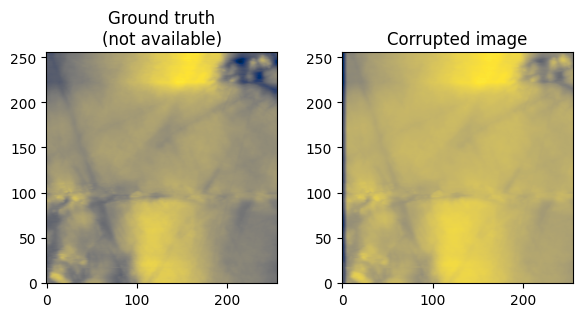

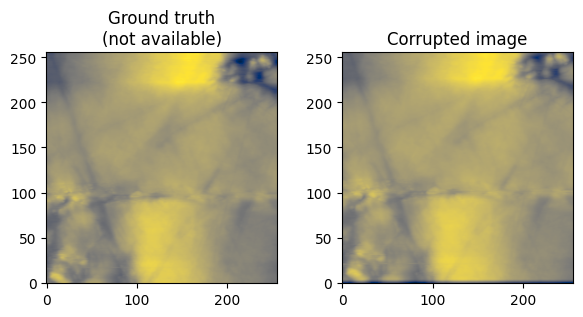

In [6]:
for i in range(2):
  # just blunt
  if i == 0:
    r_tip = 0.05797656759390918  # Radius of the blunt tip
    center = [0.48369636254267434, 0.25282428533516677]  # Tip location
  if i==1:
    r_tip = 0.07502702827007501  # Radius of the blunt tip
    center = [0.32921403408382033, 0.428570173327472]  # Tip location

  kwargs = {'effect': 'real_tip', 'r_tip': r_tip, 'center': center}
  mod_dict = [{'effect': 'real_tip', 'kwargs': kwargs}]
  #scan without modification
  array_list, shape, dtype  =  mic_server.get_scan(channels=['HeightRetrace'], modification=None)
  dat0 =  np.array(array_list, dtype=dtype).reshape(shape)
  # scan with mods
  array_list, shape, dtype = mic_server.get_scan(channels=['HeightRetrace',], modification=mod_dict)
  dat1 = np.array(array_list, dtype=dtype).reshape(shape)


  fig, ax = plt.subplots(1, 2, figsize=(7,3))

  ax[0].imshow(dat0[0].T, cmap='cividis', origin='lower')
  ax[0].set_title('Ground truth\n(not available)')
  ax[1].imshow(dat1[0].T, cmap='cividis', origin='lower')
  ax[1].set_title('Corrupted image')
  plt.show()
  gt = dat0[0].T
  # save as pngs
  plt.imsave('ground_truth.png', dat0[0], cmap='cividis', origin='lower')
  if i == 0:
    corrupted_image1 = dat1[0]
  else:
    corrupted_image2 = dat1[0]

Generating Test Data

In [7]:
!pip install torchmetrics


In [8]:
import torch
import torch.nn as nn
import numpy as np
from torch.utils.data import Dataset, DataLoader, Subset, RandomSampler
import torch.optim as optim
import torchvision.transforms.functional as F
import torchvision.transforms as transforms
import os
import random
from scipy.ndimage import gaussian_filter, median_filter
from matplotlib import pyplot as plt
from tqdm import tqdm
from torchmetrics.functional import structural_similarity_index_measure as ssim


from pathlib import Path

In [9]:
# Custom transformation for random rotation
class RandomRotation_(object):
    '''
    Randomly rotates the image by an angle chosen from a list of angles.
    '''
    def __init__(self, angles):
        self.angles = angles

    def __call__(self, img):
        img.transpose(0,1)
        angle = random.choice(self.angles)
        img_ =  F.rotate(img, angle)
        img_.transpose(0,1)
        return img_


In [10]:
class AFM_double_tip_dataset(Dataset):
    def __init__(self, length = 1500):
        '''
        NOTE: Since the dataset provided only has one ground truth, I will only have one image in the images folder.
              If using in a pipeline for training, this should be changed!
        Args:
            length (int): size of dataset you want to generate
        '''
        self.length = length

        # Get the original scans
        array_list, shape, dtype = mic_server.get_scan(channels=['HeightRetrace'], modification=None)
        self.images = [torch.tensor(array_list).float()]
        # max/min normalise now, rather than at every __getitem__()


        # list of transforms to apply to both original image and corrupted
        self.transforms_both = transforms.Compose([
            RandomRotation_([0, 90, 180, 270])
            ])

    def __len__(self):
        return self.length

    def __getitem__(self, idx):
        # get the corrupted scan
        # do (blunt) double tip with 50% chance, rest of time do blunt tip only

      #  if np.random.rand() > 0.5:
            # double tip
      #      r_tip = np.random.uniform(0.2, 0.8, (2,)).tolist()  # Radius of the blunt tip
      #      center = np.random.uniform(0.2, 0.8, (2,2)).tolist()  # Tips location
      #      length_coefs = np.random.uniform(0.2, 1, (2,)).tolist()

      #      kwargs = {'r_tip': r_tip, 'center': center, 'length_coef': length_coefs}
      #      mod_dict = [{'effect': 'tip_doubling', 'kwargs': kwargs},]
      #  else:
        # just blunt
        r_tip = np.random.uniform(0.2, 0.4)  # Radius of the blunt tip
        center = [np.random.uniform(0.2, 0.5), np.random.uniform(0.2, 0.5)]  # Tip location

        kwargs = {'effect': 'real_tip', 'r_tip': r_tip, 'center': center}
        mod_dict = [{'effect': 'real_tip', 'kwargs': kwargs}]


        array_list, shape, dtype = mic_server.get_scan(channels=['HeightRetrace'], modification=mod_dict)
        corrupted = torch.tensor(array_list).float()

        # max/min normalization
        corrupted = (corrupted-torch.min(corrupted))/(torch.max(corrupted)-torch.min(corrupted))

        # get true image
        image = self.images[0]

        # stack them so they can be rotated together
        both = torch.stack([image, corrupted])
        # transforms_both returns the original image (in first channel), and the double tip image in zeroth channel
        both = self.transforms_both(both)

        # We crop it to increase dataset size
       # image = transforms.RandomCrop(128)(image)

        # The "label" is the original image, the "image" is the image with the double tip
        label = both[0,:,:]
        corrupted = both[1,:,:]


        # max/min normalization
        corrupted = (corrupted-torch.min(corrupted))/(torch.max(corrupted)-torch.min(corrupted))
        label = (label-torch.min(label))/(torch.max(label)-torch.min(label))

        return corrupted.float(), label.float()


In [11]:
dataset_train = AFM_double_tip_dataset(length=500)#
dataset_test = AFM_double_tip_dataset(length=50)

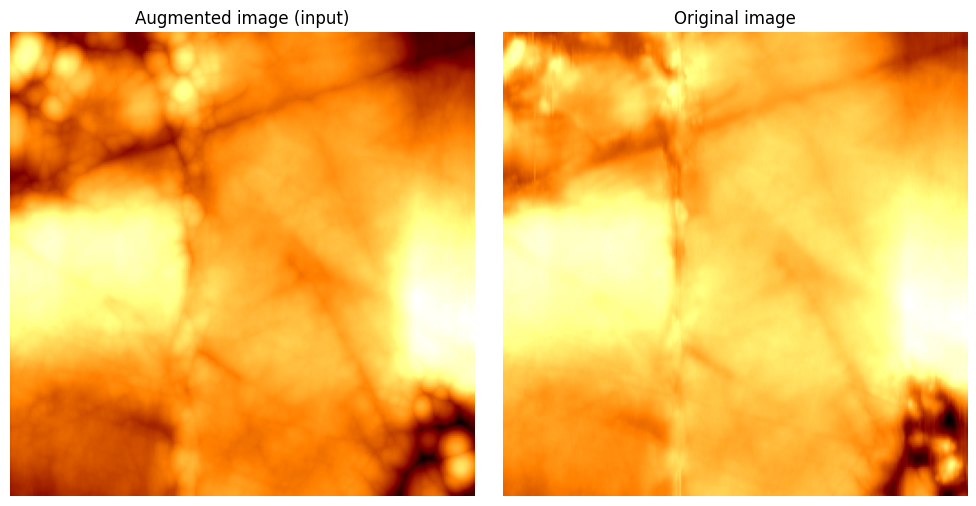

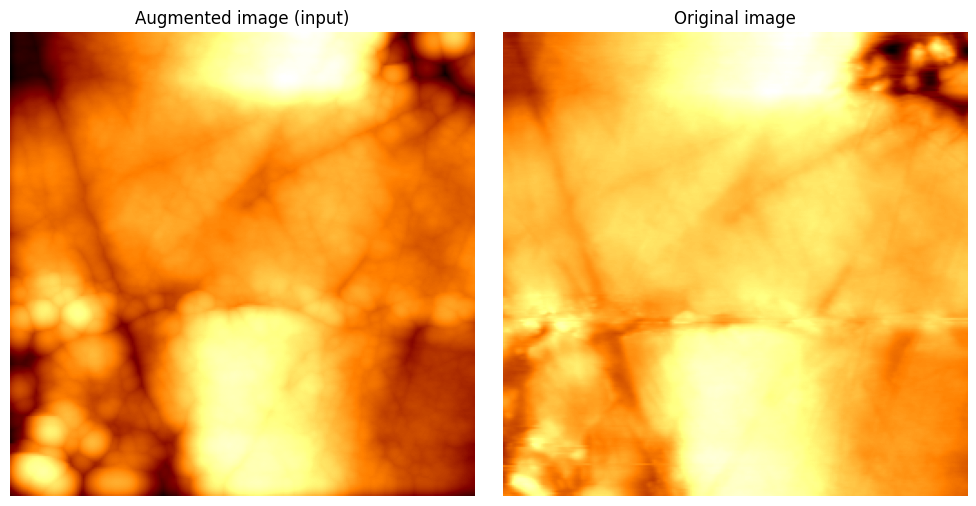

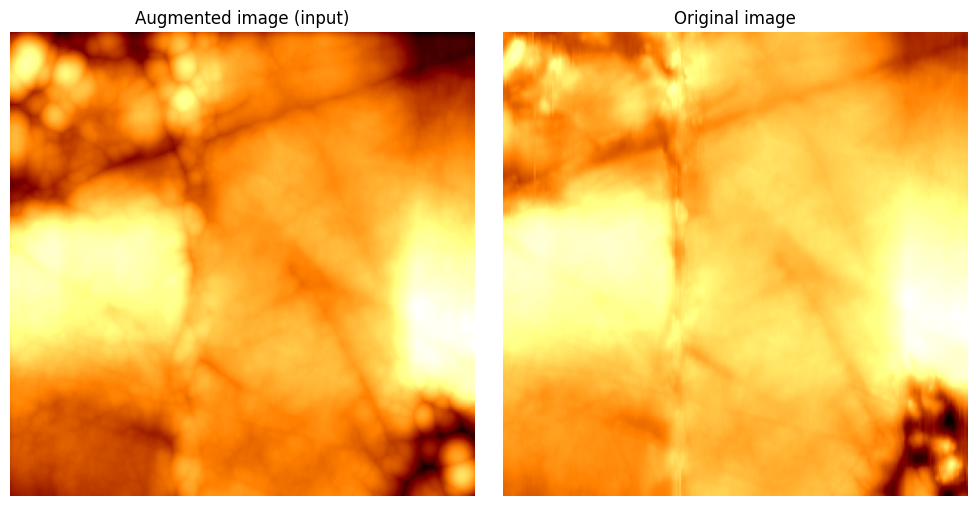

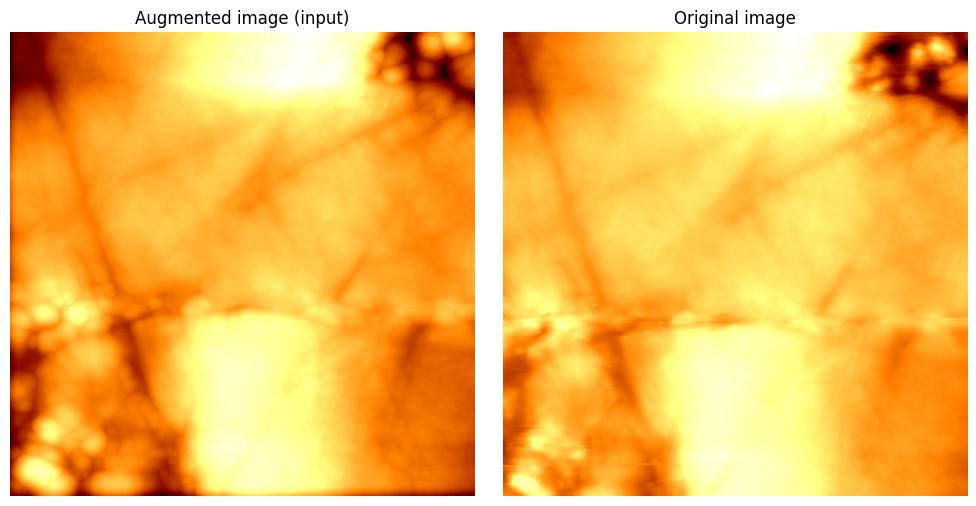

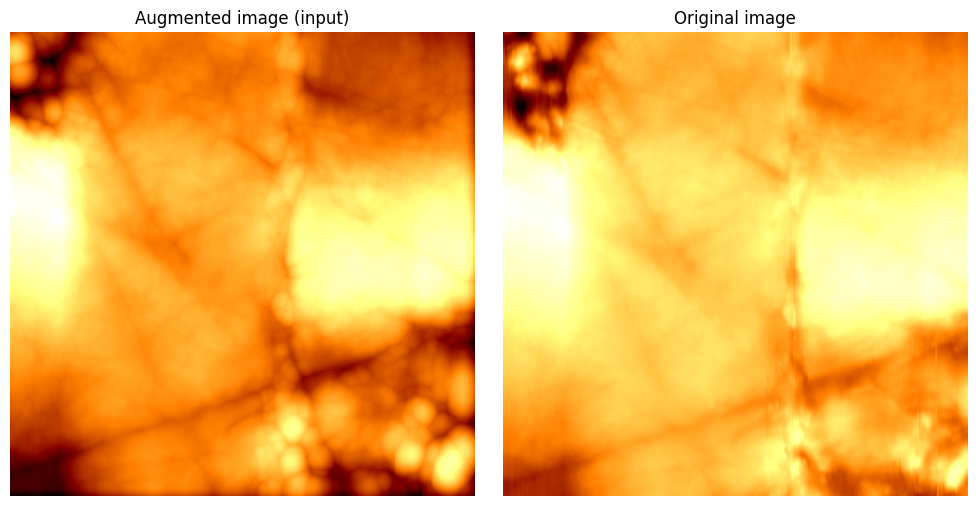

In [12]:
# plot 10 images
for i in range(5):
  imgs = dataset_train[i]
  img1 = imgs[0].numpy()[0,:,:]
  img2 = imgs[1].numpy()[0,:,:]
  fig, axes = plt.subplots(1, 2, figsize=(10, 5))
  # Display the first image
  axes[0].imshow(img1, cmap='afmhot')
  axes[0].axis('off')  # Hide axes
  axes[0].set_title('Augmented image (input)')

  # Display the second image
  axes[1].imshow(img2, cmap='afmhot')
  axes[1].axis('off')
  axes[1].set_title('Original image')

  # Adjust layout
  plt.tight_layout()

  # Show the plot
  plt.show()

In [13]:
# create dataloaders and samplers (we want to sample without replacement)
batchSize = 32
sampler_train = RandomSampler(dataset_train, replacement=False)
sampler_test = RandomSampler(dataset_test, replacement=False)
data_loaders_train = DataLoader(dataset_train, sampler=sampler_train, batch_size=batchSize)
data_loaders_test = DataLoader(dataset_test, sampler=sampler_test, batch_size=batchSize)

In [14]:
class Autoencoder(nn.Module):
    def __init__(self):
        super(Autoencoder, self).__init__()

        # Encoder
        self.encoder = nn.Sequential(nn.Conv2d(1,32, kernel_size=3, padding='same'),
                                     nn.ReLU(inplace=True),
                                     nn.BatchNorm2d(32),
                                     nn.Conv2d(32,32, kernel_size=3, padding='same'),
                                     nn.ReLU(inplace=True),
                                     nn.BatchNorm2d(32),
                                     nn.Conv2d(32,64, kernel_size=3, padding='same'),
                                     nn.ReLU(inplace=True),
                                     nn.BatchNorm2d(64),
                                     nn.Conv2d(64,64, kernel_size=3, padding='same'),
                                     nn.ReLU(inplace=True),
                                     nn.BatchNorm2d(64),
                                     nn.MaxPool2d(2,2)
        )

        # Bottleneck
        self.bottleneck = nn.Sequential(nn.Conv2d(64,128, kernel_size=3, padding='same'),
                                         nn.ReLU(inplace=True),
                                         nn.BatchNorm2d(128),
                                         nn.Conv2d(128,128, kernel_size=3, padding='same'),
                                         nn.ReLU(inplace=True),
                                         nn.BatchNorm2d(128),
        )

        self.decoder = nn.Sequential(nn.Upsample(scale_factor=2, mode='bilinear'),
                                     nn.Conv2d(128, 64, kernel_size=3, padding='same'),
                                     nn.ReLU(inplace=True),
                                     nn.BatchNorm2d(64),
                                     nn.Conv2d(64, 64, kernel_size=3, padding='same'),
                                     nn.ReLU(inplace=True),
                                     nn.BatchNorm2d(64),
                                     nn.Conv2d(64, 32, kernel_size=3, padding='same'),
                                     nn.ReLU(inplace=True),
                                     nn.BatchNorm2d(32),
                                     nn.Conv2d(32, 32, kernel_size=3, padding='same'),
                                     nn.ReLU(inplace=True),
                                     nn.BatchNorm2d(32),
                                     nn.Conv2d(32, 1, kernel_size=1),
                                     nn.Tanh()
        )

    def forward(self, x):
        # Encoding path
        enc = self.encoder(x)

        # Bottleneck
        bottleneck = self.bottleneck(enc)

        # Decoding path
        out = self.decoder(bottleneck)

        return out

In [15]:
def train_autoencoder(model, dataloader_train, dataloader_test, loss_fn, optimizer, scheduler,
                      patience, num_epochs, model_name, device="cuda", diff=False):
    """
    Train an autoencoder model and save the best-performing version based on validation loss.

    Args:
        model (torch.nn.Module): The autoencoder model to train.
        dataloader_train (DataLoader): DataLoader for training data.
        dataloader_test (DataLoader): DataLoader for validation data.
        loss_fn (torch.nn.Module): Loss function (e.g., MSELoss).
        optimizer (torch.optim.Optimizer): Optimizer for model parameters.
        scheduler (torch.optim.lr_scheduler): Learning rate scheduler.
        patience (int): Number of epochs to wait for improvement in validation loss.
        num_epochs (int): Number of epochs to train.
        model_name (str): Path to save the best model.
        device (str): Device to use for training (e.g., "cuda" or "cpu").
        diff (Bool): If true, the model predicts noise/double tip, not the final image

    Returns:
        dict: Training history containing train and validation loss per epoch.
    """
    # Move model to device
    model = model.to(device)
    best_loss = float("inf")  # Track best validation loss
    history = {"train_loss": [], "val_loss": []}
    early_stopping = 0

    for epoch in range(num_epochs):
        print(f"Epoch {epoch + 1}/{num_epochs}")
        print("-" * 50)

        # Training phase
        model.train()
        train_loss = 0.0

        # Wrap the dataloader with tqdm for progress bar
        progress_bar = tqdm(dataloader_train, desc=f"Epoch {epoch+1}/{num_epochs}", leave=False)


        for inputs, labels in progress_bar:
            inputs = inputs.to(device)
            # labels is the perfect image
            labels = labels.to(device)
            if diff:
              # labels becomes the "noise"/"double tip" part
              labels = inputs - labels
            # Forward pass
            outputs = model(inputs)
            loss = loss_fn(outputs, labels)  # Compare output to input (reconstruction)

            # Backward pass and optimization
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            # Track loss
            train_loss += loss.item()

        train_loss /= len(dataloader_train)

        # Validation phase
        model.eval()
        val_loss = 0.0

        with torch.no_grad():
            # Wrap the dataloader with tqdm for progress bar
            progress_bar_val = tqdm(dataloader_test, desc=f"Epoch {epoch+1}/{num_epochs}", leave=False)

            for inputs, labels in progress_bar_val:
                inputs = inputs.to(device)
                labels = labels.to(device)
                if diff:
                    labels = inputs - labels

                # Forward pass
                outputs = model(inputs)
                loss = loss_fn(outputs, labels)

                # Track loss
                val_loss += loss.item()

        val_loss /= len(dataloader_test)

        # update lr if val_loss unchanged
        scheduler.step(val_loss)

        # Save the best model
        if val_loss < best_loss:
            best_loss = val_loss
            torch.save(model.state_dict(), model_name)
            print(f"Best model saved with validation loss: {val_loss:.4f}")
            print("-" * 50)
            early_stopping = 0
        else:
          early_stopping +=1

        if early_stopping > patience:
          print("Early stopping")
          break


        # Print epoch summary
        print("-" * 50)
        print(f"Train Loss: {train_loss:.4f} | Validation Loss: {val_loss:.4f}")
        print("-" * 50)
        # Store metrics in history
        history["train_loss"].append(train_loss)
        history["val_loss"].append(val_loss)

    return history


In [16]:
class SSIM_L1_Loss(nn.Module):
    def __init__(self, alpha=0.5):
        """
        Custom loss combining SSIM and L1 Loss.
        Args:
            alpha (float): Weight for SSIM and L1 loss combination.
                           alpha=0.5 gives equal importance to both losses.
        """
        super(SSIM_L1_Loss, self).__init__()
        self.alpha = alpha
        self.l1_loss = nn.L1Loss()

    def forward(self, predictions, targets):
        """
        Compute the combined SSIM and L1 loss.
        Args:
            predictions: Predicted images (B, C, H, W).
            targets: Ground truth images (B, C, H, W).
        Returns:
            Combined loss value.
        """
        # SSIM loss (SSIM ranges from -1 to 1, so 1 - SSIM is treated as the loss)
        ssim_value = ssim(predictions, targets, data_range=1.0)  # SSIM score
        ssim_loss = 1 - ssim_value  # Convert SSIM to loss (lower SSIM = higher loss)

        # L1 loss
        l1_loss = self.l1_loss(predictions, targets)

        # Combined loss
        combined_loss = self.alpha * ssim_loss + (1 - self.alpha) * l1_loss
        return combined_loss


In [17]:
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using {device} device")

Using cuda device


In [18]:
# Function to save the model
def save_model(model, path):
    torch.save(model.state_dict(), path)

In [19]:
from functools import lru_cache
# Create the model
autoencoder = Autoencoder()

# Loss and Optimizer
#criterion = nn.MSELoss()
#criterion = nn.L1Loss()
criterion = SSIM_L1_Loss()
optimizer = optim.Adam(autoencoder.parameters(), lr=0.001)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min')

In [24]:
# Train the autoencoder
history = train_autoencoder(
    model=autoencoder,
    dataloader_train= data_loaders_train,
    dataloader_test= data_loaders_test,
    loss_fn=criterion,
    optimizer=optimizer,
    scheduler=scheduler,
    patience = 25,
    num_epochs=60,
    model_name="best_autoencoder.pth",
    device = device, # "cpu" #,
    diff = True
)
# 35 epochs

Epoch 1/60
--------------------------------------------------


Best model saved with validation loss: 0.1061
--------------------------------------------------
--------------------------------------------------
Train Loss: 0.0984 | Validation Loss: 0.1061
--------------------------------------------------
Epoch 2/60
--------------------------------------------------


Best model saved with validation loss: 0.1028
--------------------------------------------------
--------------------------------------------------
Train Loss: 0.0955 | Validation Loss: 0.1028
--------------------------------------------------
Epoch 3/60
--------------------------------------------------


--------------------------------------------------
Train Loss: 0.0990 | Validation Loss: 0.1034
--------------------------------------------------
Epoch 4/60
--------------------------------------------------


Best model saved with validation loss: 0.0979
--------------------------------------------------
--------------------------------------------------
Train Loss: 0.0952 | Validation Loss: 0.0979
--------------------------------------------------
Epoch 5/60
--------------------------------------------------


Best model saved with validation loss: 0.0920
--------------------------------------------------
--------------------------------------------------
Train Loss: 0.0959 | Validation Loss: 0.0920
--------------------------------------------------
Epoch 6/60
--------------------------------------------------


--------------------------------------------------
Train Loss: 0.0957 | Validation Loss: 0.0987
--------------------------------------------------
Epoch 7/60
--------------------------------------------------


KeyboardInterrupt: 

In [ ]:
# Load the best autoencoder model
autoencoder.load_state_dict(torch.load("best_autoencoder_diff.pth",map_location=torch.device('cpu')))
autoencoder.to(device)
autoencoder.eval()

<ipython-input-95-5f3d0d887ed9>:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  autoencoder.load_state_dict(torch.load("best_autoencoder.pth",map_location=torch.device('cpu

Autoencoder(
  (encoder): Sequential(
    (0): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=same)
    (1): ReLU(inplace=True)
    (2): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=same)
    (4): ReLU(inplace=True)
    (5): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=same)
    (7): ReLU(inplace=True)
    (8): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (9): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=same)
    (10): ReLU(inplace=True)
    (11): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (12): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (bottleneck): Sequential(
    (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=same)
    (1): R

In [ ]:
!pip install piq


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 106.9/106.9 kB 3.7 MB/s eta 0:00:00


In [ ]:
from skimage.metrics import structural_similarity as ssim
from skimage import io, color

from piq import vif_p

In [ ]:
def calculate_psnr(img1, img2, max_value=255):
    """"Calculating peak signal-to-noise ratio (PSNR) between two images."""
    mse = np.mean((np.array(img1, dtype=np.float32) - np.array(img2, dtype=np.float32)) ** 2)
    if mse == 0:
        return 100
    return 20 * np.log10(max_value / (np.sqrt(mse)))

In [ ]:
# Load the images
corrupted_image1 = color.rgb2gray(io.imread('corrupted_rtip_0.05797656759390918_center_[0.48369636254267434, 0.25282428533516677].png')[:,:,:3])
corrupted_image2 = color.rgb2gray(io.imread('corrupted_rtip_0.07502702827007501_center_[0.32921403408382033, 0.428570173327472].png')[:,:,:3])
corrupted_recons1 = io.imread('corrupted_rtip_0.05797656759390918_center_[0.48369636254267434, 0.25282428533516677]_reconstruction.png')
corrupted_recons2 = io.imread('corrupted_rtip_0.07502702827007501_center_[0.32921403408382033, 0.428570173327472]_reconstruction.png')



In [ ]:
# get model pred
# turn input to tensor and the max/min normalise
corrupted_image1_tensor = torch.Tensor(corrupted_image1).unsqueeze(0).unsqueeze(0).to(device)
corrupted_image2_tensor = torch.Tensor(corrupted_image2).unsqueeze(0).unsqueeze(0).to(device)

corrupted_image1_tensor = (corrupted_image1_tensor-torch.min(corrupted_image1_tensor))/(torch.max(corrupted_image1_tensor)-torch.min(corrupted_image1_tensor))
corrupted_image2_tensor = (corrupted_image2_tensor-torch.min(corrupted_image2_tensor))/(torch.max(corrupted_image2_tensor)-torch.min(corrupted_image2_tensor))

# get reconstructed image from model
reconstructed_image1 = corrupted_image1 - autoencoder(corrupted_image1_tensor).detach().numpy()[0,0,:,:]
reconstructed_image2 = corrupted_image1 - autoencoder(corrupted_image2_tensor).detach().numpy()[0,0,:,:]


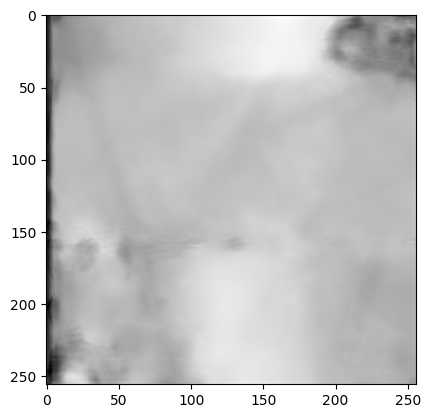

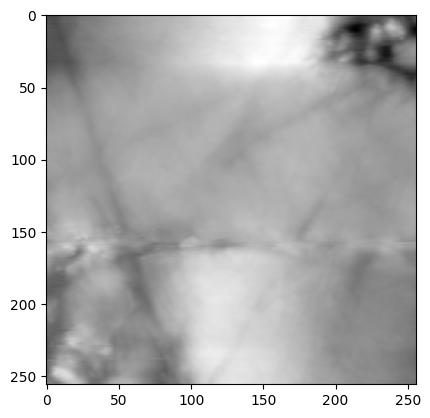

In [ ]:
plt.imshow(reconstructed_image1, cmap='gray')
plt.show()
plt.imshow(gt[::-1], cmap='gray')
plt.show()

In [ ]:
gt = gt/np.max(gt)

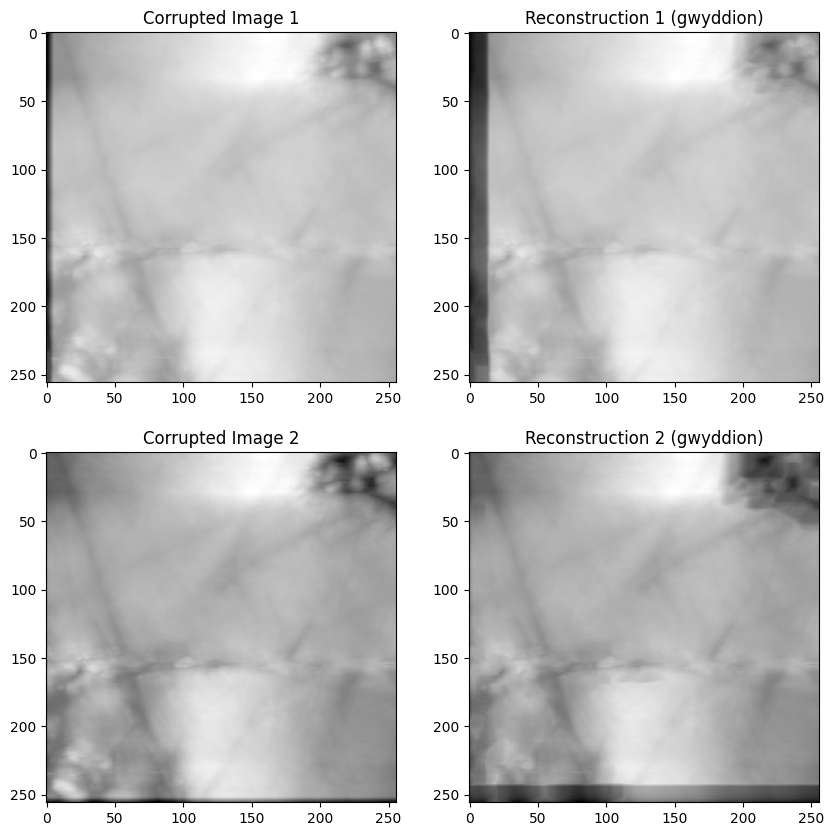

In [ ]:
# Assuming corrupted_image1, corrupted_image2, corrupted_recons1, and corrupted_recons2 are defined as in the provided code.

fig, axes = plt.subplots(2, 2, figsize=(10, 10))

axes[0, 0].imshow(corrupted_image1, cmap='gray')
axes[0, 0].set_title('Corrupted Image 1')
axes[0, 1].imshow(corrupted_recons1, cmap='gray')
axes[0, 1].set_title('Reconstruction 1 (gwyddion)')

axes[1, 0].imshow(corrupted_image2, cmap='gray')
axes[1, 0].set_title('Corrupted Image 2')
axes[1, 1].imshow(corrupted_recons2, cmap='gray')
axes[1, 1].set_title('Reconstruction 2 (gwyddion)')


plt.show()

In [ ]:
corrupted_image1.shape

(256, 256)

In [ ]:
# Calculate the SSIM scores
data_range = gt.max() - gt.min()  # Calculate data range of the ground truth image

ssim_score11, diff11 = ssim(gt[::-1,:], corrupted_image1, full=True, data_range=data_range)
ssim_score21, diff21 = ssim(gt[::-1,:], corrupted_image2, full=True, data_range=data_range)
ssim_score12, diff12 = ssim(gt[::-1,:], corrupted_recons1, full=True, data_range=data_range)
ssim_score22, diff22= ssim(gt[::-1,:], corrupted_recons2, full=True, data_range=data_range)

ssim_score13, diff13 = ssim(gt[::-1,:], reconstructed_image1, full=True, data_range=data_range)
ssim_score23, diff23 = ssim(gt[::-1,:], reconstructed_image2, full=True, data_range=data_range)


In [ ]:
print(f"SSIM Score for corrupted image 1: {ssim_score11}")
print(f"SSIM Score for corrupted image 2: {ssim_score21}")
print(f"SSIM Score for reconstructed image 1: {ssim_score12}")
print(f"SSIM Score for reconstructed image 2: {ssim_score22}")
print(f"SSIM Score for reconstructed image 1: {ssim_score13}")
print(f"SSIM Score for reconstructed image 2: {ssim_score23}")

SSIM Score for corrupted image 1: 0.8259736512087694
SSIM Score for corrupted image 2: 0.8541734515472545
SSIM Score for reconstructed image 1: 6.677055169185076e-09
SSIM Score for reconstructed image 2: 5.499635967599506e-10
SSIM Score for reconstructed image 1: 0.8114256962827496
SSIM Score for reconstructed image 2: 0.7257817861363609


In [ ]:
# make 1 the max for all as needed for psnr
corrupted_image1 = (corrupted_image1)/(np.max(corrupted_image1))
corrupted_image2 = (corrupted_image2)/(np.max(corrupted_image2))
corrupted_recons1 = (corrupted_recons1)/(np.max(corrupted_recons1))
corrupted_recons2 = (corrupted_recons2)/(np.max(corrupted_recons2))
reconstructed_image1 = (reconstructed_image1)/(np.max(reconstructed_image1))
reconstructed_image2 = (reconstructed_image2)/(np.max(reconstructed_image2))

In [ ]:
psnr11 = calculate_psnr(gt[::-1,:], corrupted_image1, max_value=1)
psnr21 = calculate_psnr(gt[::-1,:], corrupted_image2, max_value=1)
psnr12 = calculate_psnr(gt[::-1,:], corrupted_recons1, max_value=1)
psnr22 = calculate_psnr(gt[::-1,:], corrupted_recons2, max_value=1)
psnr13 = calculate_psnr(gt[::-1,:], reconstructed_image1, max_value=1)
psnr23 = calculate_psnr(gt[::-1,:], reconstructed_image1, max_value=1)

In [ ]:
print(f"PSNR Score for corrupted image 1: {psnr11}")
print(f"PSNR Score for corrupted image 2: {psnr21}")
print(f"PSNR Score for reconstructed image 1: {psnr12}")
print(f"PSNR Score for reconstructed image 2: {psnr22}")
print(f"PSNR Score for reconstructed image 1: {psnr13}")
print(f"PSNR Score for reconstructed image 2: {psnr23}")

PSNR Score for corrupted image 1: 16.685099103332245
PSNR Score for corrupted image 2: 24.772899814400574
PSNR Score for reconstructed image 1: 16.524784466201513
PSNR Score for reconstructed image 2: 22.14170724239701
PSNR Score for reconstructed image 1: 15.34908558903176
PSNR Score for reconstructed image 2: 15.34908558903176


In [ ]:
# make max/min = 0/1 for VIF
corrupted_image1 = (corrupted_image1-np.min(corrupted_image1))/(np.max(corrupted_image1)-np.min(corrupted_image1))
corrupted_image2 = (corrupted_image2-np.min(corrupted_image2))/(np.max(corrupted_image2)-np.min(corrupted_image2))
corrupted_recons1 = (corrupted_recons1-np.min(corrupted_recons1))/(np.max(corrupted_recons1)-np.min(corrupted_recons1))
corrupted_recons2 = (corrupted_recons2-np.min(corrupted_recons2))/(np.max(corrupted_recons2)-np.min(corrupted_recons2))
reconstructed_image1 = (reconstructed_image1-np.min(reconstructed_image1))/(np.max(reconstructed_image1)-np.min(reconstructed_image1))
reconstructed_image2 = (reconstructed_image2-np.min(reconstructed_image2))/(np.max(reconstructed_image2)-np.min(reconstructed_image2))

gt = (gt-np.min(gt))/(np.max(gt)-np.min(gt))

In [ ]:
from piq import vif_p
import torch

# images need to be between 0 and 1
# need to be torch tensors

gt_tensor = torch.Tensor(gt).unsqueeze(0).unsqueeze(0)
torchcorrupted_image1 = torch.Tensor(corrupted_image1).unsqueeze(0).unsqueeze(0)
torchcorrupted_image2 = torch.Tensor(corrupted_image2).unsqueeze(0).unsqueeze(0)
torchcorrupted_recons1 = torch.Tensor(corrupted_recons1).unsqueeze(0).unsqueeze(0)
torchcorrupted_recons2 = torch.Tensor(corrupted_recons2).unsqueeze(0).unsqueeze(0)
torchreconstructed_image1 = torch.Tensor(reconstructed_image1).unsqueeze(0).unsqueeze(0)
torchreconstructed_image2 = torch.Tensor(reconstructed_image2).unsqueeze(0).unsqueeze(0)

vif_value1 = vif_p(gt_tensor, torchcorrupted_image1)
vif_value2 = vif_p(gt_tensor, torchcorrupted_image2)
vif_value3 = vif_p(gt_tensor, torchcorrupted_recons1)
vif_value4 = vif_p(gt_tensor, torchcorrupted_recons2)
vif_value5 = vif_p(gt_tensor, torchreconstructed_image1)
vif_value6 = vif_p(gt_tensor, torchreconstructed_image2)

In [ ]:
print(f"VIF Score for corrupted image 1: {vif_value1}")
print(f"VIF Score for corrupted image 2: {vif_value2}")
print(f"VIF Score for reconstructed image 1: {vif_value3}")
print(f"VIF Score for reconstructed image 2: {vif_value4}")
print(f"VIF Score for reconstructed image 1: {vif_value5}")
print(f"VIF Score for reconstructed image 2: {vif_value6}")

VIF Score for corrupted image 1: 0.08580490946769714
VIF Score for corrupted image 2: 0.06888308376073837
VIF Score for reconstructed image 1: 0.08636660128831863
VIF Score for reconstructed image 2: 0.06303965300321579
VIF Score for reconstructed image 1: 0.10374119877815247
VIF Score for reconstructed image 2: 0.05721402168273926
